# Pneumonia Detection using X-Ray Images
<font size = 5> Hazem Mohamed Abdelghafar 211001615</font>


<font size = 8>What is Pneumonia?</font> <br><br>
<font size = 3><b> Pneumonia is an inflammatory condition of the lung affecting primarily the small air sacs known as alveoli. Symptoms typically include some combination of productive or dry cough, chest pain, fever and difficulty in breathing. The severity of the condition is variable. Pneumonia is usually caused by infection with viruses or bacteria and less commonly by other microorganisms, certain medications or conditions such as autoimmune diseases. Risk factors include cystic fibrosis, chronic obstructive pulmonary disease (COPD), asthma, diabetes, heart failure, a history of smoking, a poor ability to cough such as following a stroke and a weak immune system. Diagnosis is often based on symptoms and physical examination. Chest X-ray, blood tests, and culture of the sputum may help confirm the diagnosis. The disease may be classified by where it was acquired, such as community, hospital-acquired or healthcare-associated pneumonia.</b></font>

## Library imports 

In [2]:
%load_ext chime

import os
import cv2
import chime
import random
import numpy as np
import pandas as pd
import seaborn as sns
from keras import optimizers
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.applications import VGG16
from sklearn.metrics import classification_report, confusion_matrix
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Dense, Conv2D , MaxPooling2D , Flatten , Dropout, BatchNormalization

In [3]:
chime.theme("zelda")
chime.notify_exceptions()

## Data Preprocessing

### Loading the Dataset

In section I will load the images of the dataset into a dataframe while normalizing the images to range from 0 to 1 instead of ranging from 0 to 255. The images are also resized to 500x500 pixels to reduce the computational complexity of the model. The images are then shuffled to ensure that the training and testing sets are representative of the dataset.


In [4]:
train_path = os.path.join(os.getcwd(), "input\\train")

test_path = os.path.join(os.getcwd(), "input\\test")

val_path = os.path.join(os.getcwd(), "input\\val")

training_set = [train_path, test_path, val_path]

labels = ["NORMAL", "PNEUMONIA"]  # 0 = Normal, 1 = Pneumonia

img_size = 150  # Number of pixels in each dimension

train_data = []
train_class = []
test_data = []
test_class = []
val_data = []
val_class = []


In [5]:
for x, data_dir in enumerate(training_set):
    for label_class in labels:
        label = labels.index(label_class)
        path = os.path.join(data_dir, label_class)
        for img in os.listdir(path):
            img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)  # Loading the images
            
            if img_arr is None:
                continue
            
            resized_arr = cv2.resize(img_arr, (img_size, img_size))  # Reshaping images to preferred size
            norm_image = cv2.normalize(resized_arr,None,alpha=0,beta=1,norm_type=cv2.NORM_MINMAX,dtype=cv2.CV_32F)  # Normalizing the images from range [0,1]
            
            if x == 0:
                train_data.append(norm_image)  # Adding image array to the train_data list
                train_class.append(label)      # Adding the corresponding label
            elif x == 1:
                test_data.append(norm_image)   # Adding image array to the train_data list
                test_class.append(label)        # Adding the corresponding label
            elif x == 2:
                val_data.append(norm_image)    # Adding image array to the train_data list
                val_class.append(label)        # Adding the corresponding label

In [6]:
def shuffle_data(data, label):
    """
    Shuffles the data and label in the same order
    """
    temp = list(zip(data, label))
    random.shuffle(temp)
    data,label = zip(*temp)
    data, label = list(data), list(label)
    return data, label

In [7]:
# Normal labeled images are loaded first, then Pneumonia labeled images are loaded second
# Therefore, we need to shuffle the dataset to avoid bias

train_features, train_label = shuffle_data(train_data, train_class)
test_features, test_label = shuffle_data(test_data, test_class)
val_features, val_label = shuffle_data(val_data, val_class)

In [8]:
train_features = np.array(train_features)
train_label = np.array(train_label)
val_features = np.array(val_features)
val_label = np.array(val_label)
test_features = np.array(test_features)
test_label = np.array(test_label)

### Data Augmentation

The train dataset had a total of 5216 image, 1341 of which were Normal cases and 3875 were Pneumonia cases. This is a very unbalanced dataset, so we will use data augmentation to increase the number of images in the dataset to prevent any overfitting that might occur.

I used the ImageDataGenerator class from the keras library to augment the images. The augmentation techniques used were rotation, width shift, height shift, zoom, and shear. The augmented images were then saved to a new directory and then appended to the original dataset. The new dataset had a total of 7720 images, 3845 of which were Normal cases and 3875 were Pneumonia cases.


<font size = 6><a href="./image_generator.ipynb"> Click me to open Data Augmentation notebook</a></font>

## Data Visualization

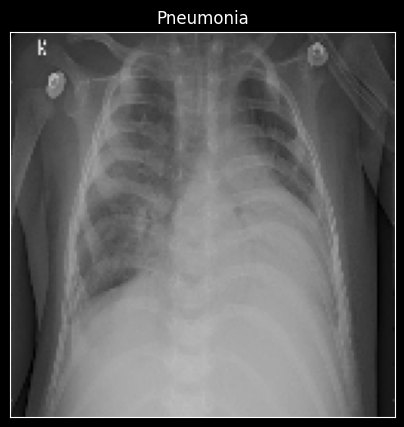

In [9]:
# Image example of the dataset
rand_num = random.randint(0, len(train_features))
plt.figure(figsize=(5, 5))
plt.imshow(train_features[rand_num], cmap="gray")
plt.title("Normal" if train_label[rand_num] == 0 else "Pneumonia")
plt.xticks([])
plt.yticks([])
plt.show()

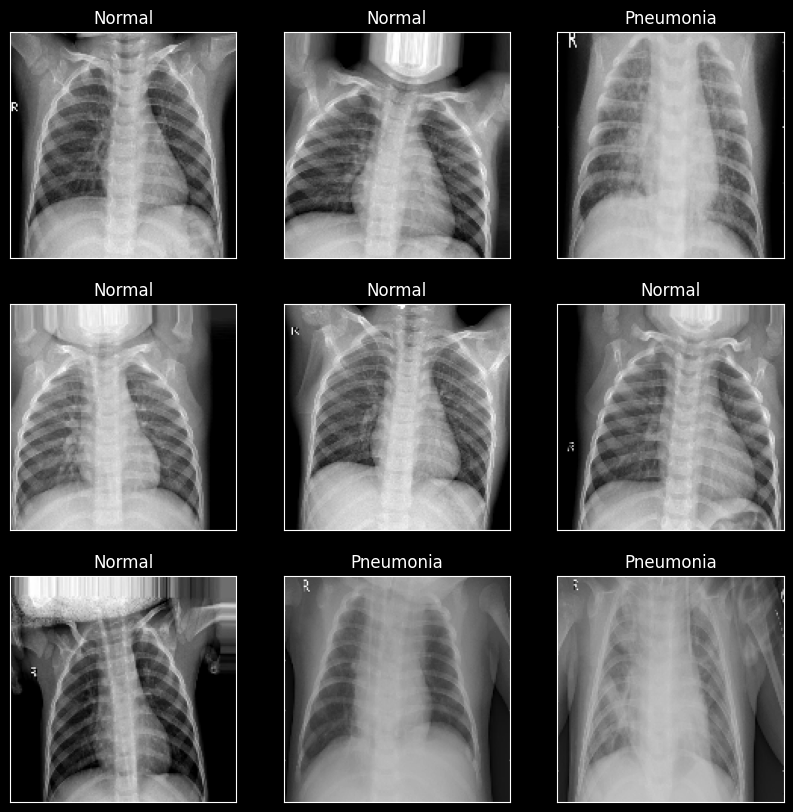

In [10]:
# visualize the data
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(train_features[i], cmap="gray")
    plt.title("Normal" if train_label[i] == 0 else "Pneumonia")
    plt.xticks([])
    plt.yticks([])
plt.show()

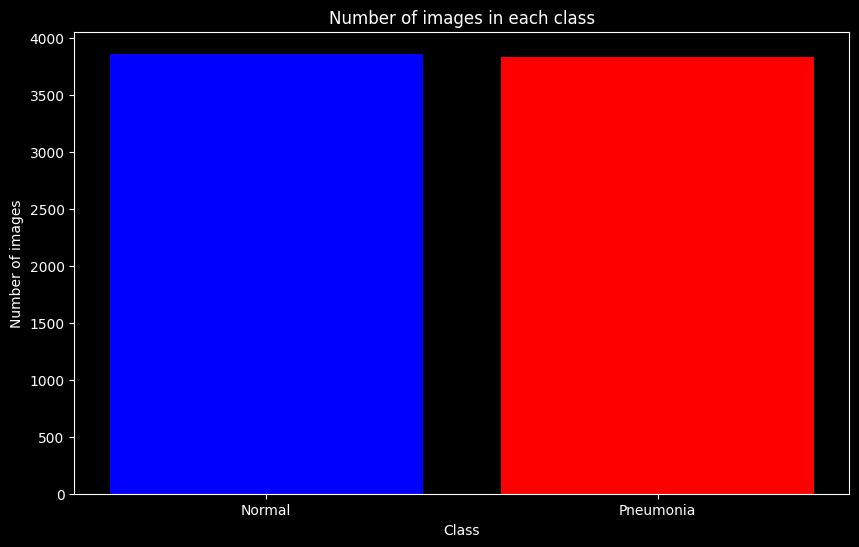

In [9]:
# Visualize the number of images in each class
df = pd.Series(train_label)

# Count the number of images in each class
class_counts = df.value_counts()
class_names = ['Normal', 'Pneumonia']  # Class names

plt.figure(figsize=(10, 6))
plt.bar(class_names, class_counts.values, color=['blue', 'red'])
plt.xlabel('Class')
plt.ylabel('Number of images')
plt.title('Number of images in each class')
plt.show()

## Neural Network Construction

### Building the CNN Model

In [12]:
model_scratch=Sequential()
model_scratch.add(Conv2D(32,(3,3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(150,150,1)))
model_scratch.add(BatchNormalization())
model_scratch.add(MaxPooling2D((2,2)))
model_scratch.add(Conv2D(64,(3,3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_scratch.add(BatchNormalization())
model_scratch.add(MaxPooling2D((2,2)))
model_scratch.add(Flatten())
model_scratch.add(Dense(128,activation='relu',kernel_initializer='he_uniform'))
model_scratch.add(Dropout(0.5))
model_scratch.add(Dense(1,activation="sigmoid"))

In [13]:
adam_optimizers = optimizers.legacy.Adamax(learning_rate=0.01)

model_scratch.compile(optimizer=adam_optimizers, loss="binary_crossentropy", metrics=['Precision', 'Recall', 'accuracy'])

In [14]:
model_scratch.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      320       
                                                                 
 batch_normalization (Batch  (None, 150, 150, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 75, 75, 64)        256       
 chNormalization)                                                
                                                        

In [15]:
# Early stopping callback
early_stopping_callback = EarlyStopping(monitor="val_accuracy",patience=5,verbose=0,mode="max",restore_best_weights=True)

# Save checkpoints during training
checkpoint_filepath = "model_scratch.h5"
model_checkpoint_callback_scratch = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor="val_accuracy",
    mode="auto",
    save_best_only=True
)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 5, verbose=1,factor=0.3, min_lr=0.00001)


In [16]:
vgg_base_model = VGG16(input_shape=(img_size,img_size,3),include_top=False,weights='imagenet')

for layer in vgg_base_model.layers:
    layer.trainable = False

In [17]:
model = Sequential()

model.add(vgg_base_model)
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(128, kernel_initializer='he_uniform', activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid"))

model.compile(optimizer = adam_optimizers,loss="binary_crossentropy",metrics=['Precision', 'Recall', 'accuracy'])

In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 batch_normalization_2 (Bat  (None, 4, 4, 512)         2048      
 chNormalization)                                                
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               1048704   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                      

In [19]:
history_scratch = model_scratch.fit(
    x=train_features,
    y=train_label,
    batch_size=64,
    epochs=10,
    steps_per_epoch=100,
    validation_data=(val_features, val_label),
    callbacks=[early_stopping_callback, model_checkpoint_callback_scratch, learning_rate_reduction],
    verbose=1,
    use_multiprocessing=False
)

Epoch 1/10
100/100 [==============================] - 68s 664ms/step - loss: 7.0889 - precision: 0.8808 - recall: 0.7565 - accuracy: 0.8269 - val_loss: 19.4623 - val_precision: 0.4948 - val_recall: 1.0000 - val_accuracy: 0.4948 - lr: 0.0100
Epoch 2/10


c:\Users\zoma_\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


100/100 [==============================] - 64s 639ms/step - loss: 0.3319 - precision: 0.9460 - recall: 0.8122 - accuracy: 0.8830 - val_loss: 32.9288 - val_precision: 0.5000 - val_recall: 1.0000 - val_accuracy: 0.5052 - lr: 0.0100
Epoch 3/10
100/100 [==============================] - 64s 637ms/step - loss: 0.2333 - precision: 0.9624 - recall: 0.8517 - accuracy: 0.9089 - val_loss: 15.6930 - val_precision: 0.5217 - val_recall: 1.0000 - val_accuracy: 0.5464 - lr: 0.0100
Epoch 4/10
100/100 [==============================] - 64s 638ms/step - loss: 0.2002 - precision: 0.9680 - recall: 0.8670 - accuracy: 0.9191 - val_loss: 4.8832 - val_precision: 0.6133 - val_recall: 0.9583 - val_accuracy: 0.6804 - lr: 0.0100
Epoch 5/10
100/100 [==============================] - 64s 642ms/step - loss: 0.1859 - precision: 0.9707 - recall: 0.8861 - accuracy: 0.9287 - val_loss: 2.4712 - val_precision: 0.7015 - val_recall: 0.9792 - val_accuracy: 0.7835 - lr: 0.0100
Epoch 6/10
100/100 [=============================

In [20]:
# Convert the grayscale images to RGB
rgb_train_data = np.repeat(train_features[..., np.newaxis], 3, -1)
rgb_val_data = np.repeat(val_features[..., np.newaxis], 3, -1)
rgb_test_data = np.repeat(test_features[..., np.newaxis], 3, -1)

# Save checkpoints during training
checkpoint_filepath = "model.h5"
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor="val_accuracy",
    mode="auto",
    save_best_only=True,
)

In [21]:
history = model.fit(
    x=rgb_train_data,
    y=train_label,
    batch_size=64,
    epochs=10,
    steps_per_epoch=100,
    validation_data=(rgb_val_data, val_label),
    callbacks=[early_stopping_callback, model_checkpoint_callback, learning_rate_reduction],
    verbose=1,
    use_multiprocessing=False
)

Epoch 1/10
100/100 [==============================] - 171s 2s/step - loss: 0.1883 - precision: 0.9443 - recall: 0.9463 - accuracy: 0.9445 - val_loss: 0.1867 - val_precision: 0.9200 - val_recall: 0.9583 - val_accuracy: 0.9381 - lr: 0.0100
Epoch 2/10
100/100 [==============================] - 181s 2s/step - loss: 0.0776 - precision: 0.9747 - recall: 0.9655 - accuracy: 0.9700 - val_loss: 0.1580 - val_precision: 0.8868 - val_recall: 0.9792 - val_accuracy: 0.9278 - lr: 0.0100
Epoch 3/10
100/100 [==============================] - 183s 2s/step - loss: 0.0545 - precision: 0.9817 - recall: 0.9739 - accuracy: 0.9781 - val_loss: 0.1781 - val_precision: 0.8868 - val_recall: 0.9792 - val_accuracy: 0.9278 - lr: 0.0100
Epoch 4/10
100/100 [==============================] - 185s 2s/step - loss: 0.0441 - precision: 0.9859 - recall: 0.9834 - accuracy: 0.9845 - val_loss: 0.2081 - val_precision: 0.8246 - val_recall: 0.9792 - val_accuracy: 0.8866 - lr: 0.0100
Epoch 5/10
100/100 [============================

## Evaluation Metrics

### Training and Validation Accuracy

#### Training and Validation Accuracy for the CNN Model

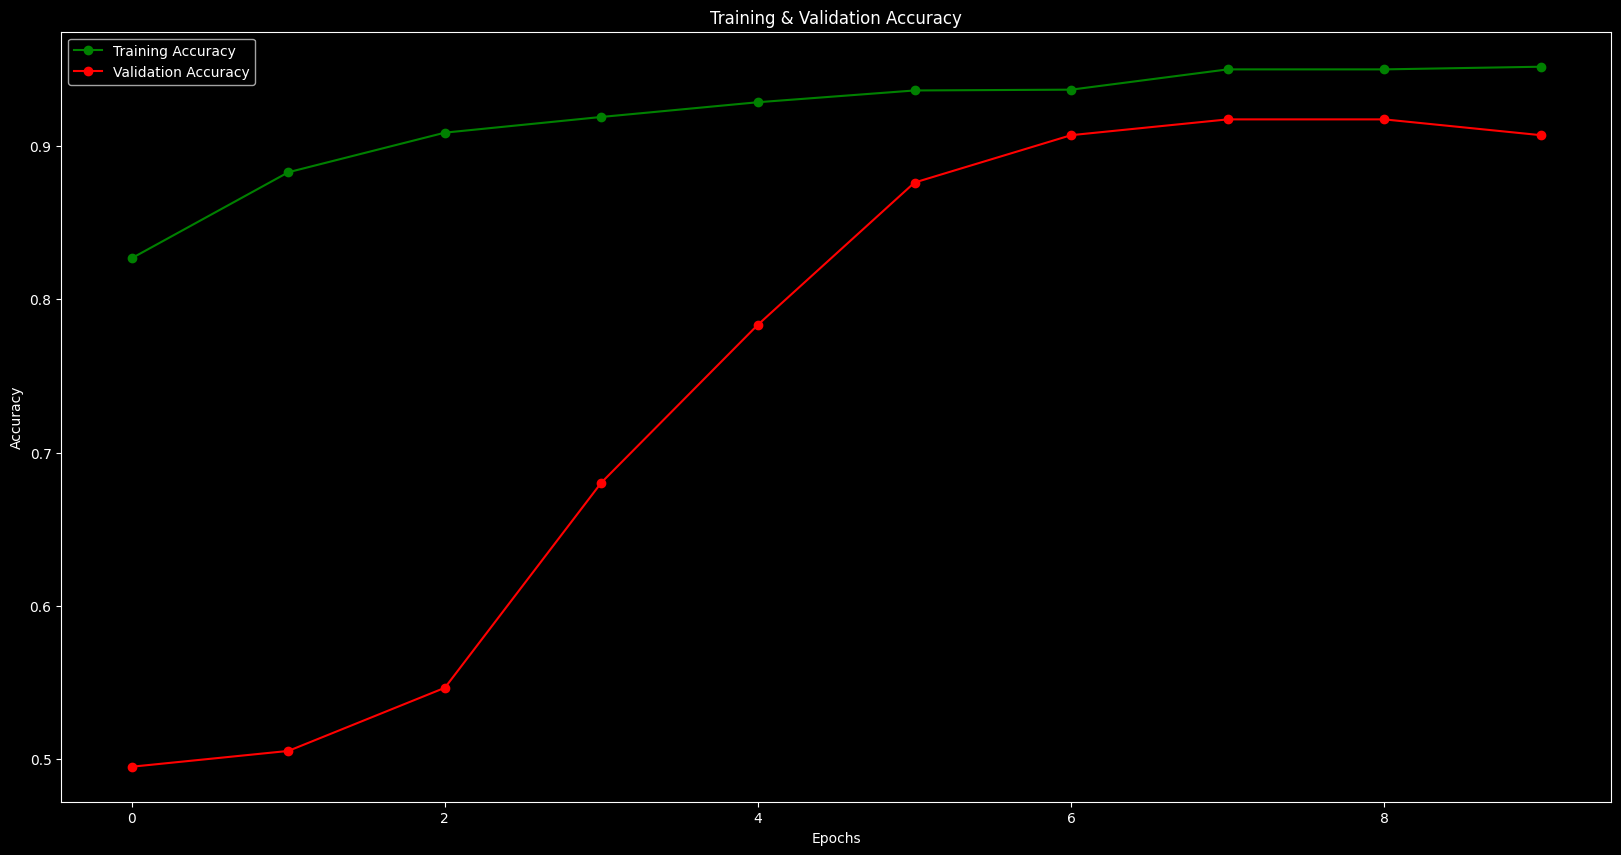

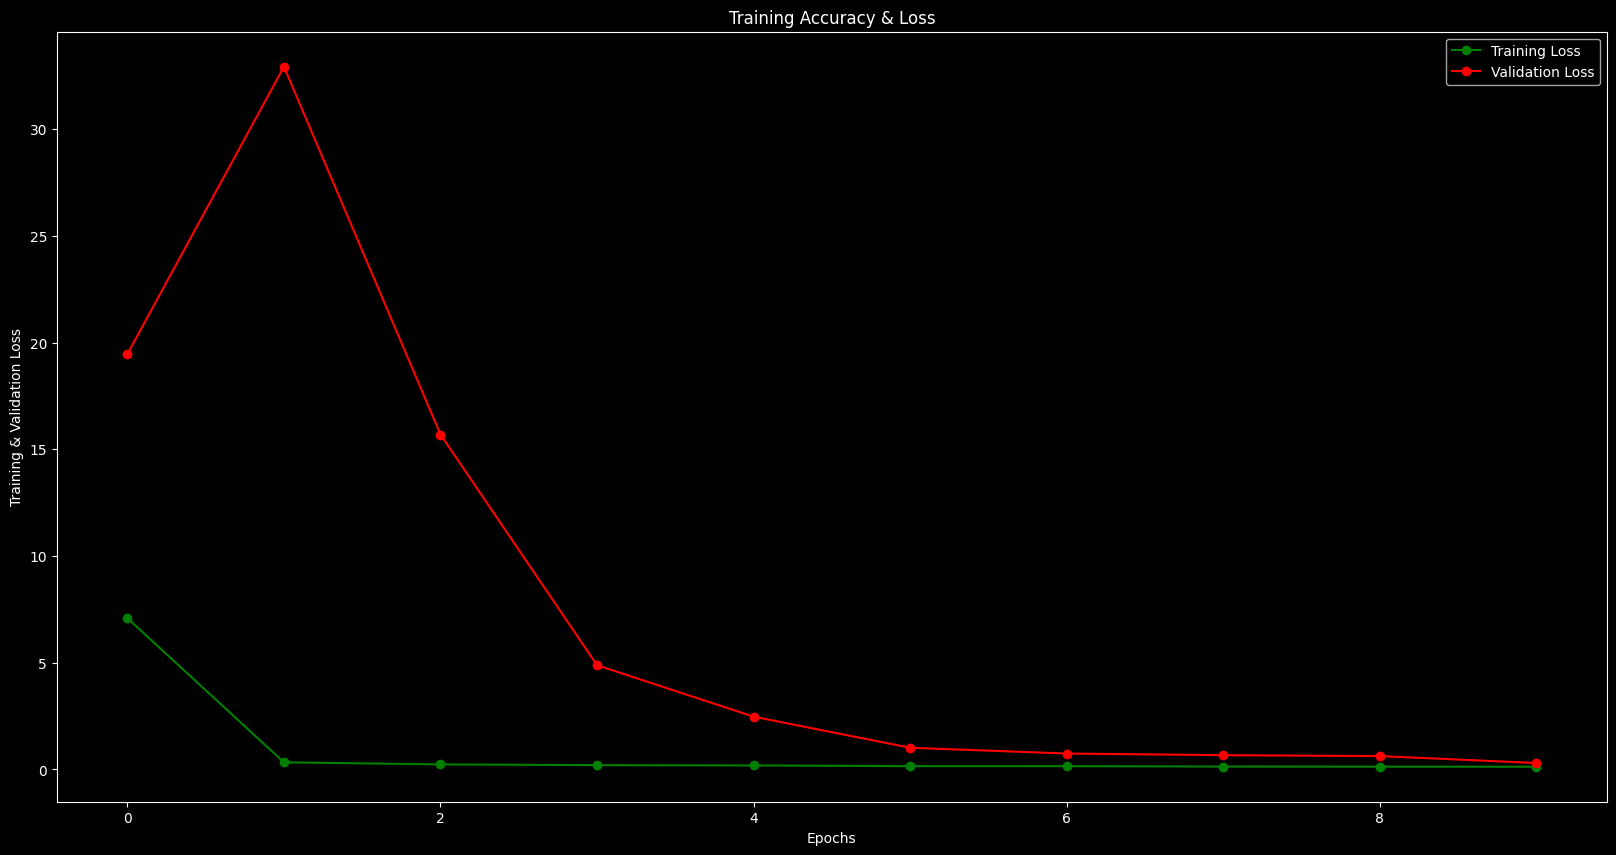

In [22]:
train_acc_scratch = history_scratch.history["accuracy"]
train_loss_scratch = history_scratch.history["loss"]
val_acc_scratch = history_scratch.history["val_accuracy"]
val_loss_scratch = history_scratch.history["val_loss"]

train_acc_df_scratch = pd.DataFrame(train_acc_scratch)
train_loss_df_scratch = pd.DataFrame(train_loss_scratch)
val_acc_df_scratch = pd.DataFrame(val_acc_scratch)
val_loss_df_scratch = pd.DataFrame(val_loss_scratch)

epochs = [i for i in range(len(train_acc_df_scratch))]

plt.figure(figsize=(20, 10))
plt.plot(epochs, train_acc_df_scratch, "go-", label="Training Accuracy")
plt.plot(epochs, val_acc_df_scratch, "ro-", label="Validation Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

plt.figure(figsize=(20, 10))
plt.plot(epochs, train_loss_df_scratch, "g-o", label="Training Loss")
plt.plot(epochs, val_loss_df_scratch, "r-o", label="Validation Loss")
plt.title("Training Accuracy & Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Training & Validation Loss")
plt.show()

#### Train and Validation accuracy for the VGG16 Model

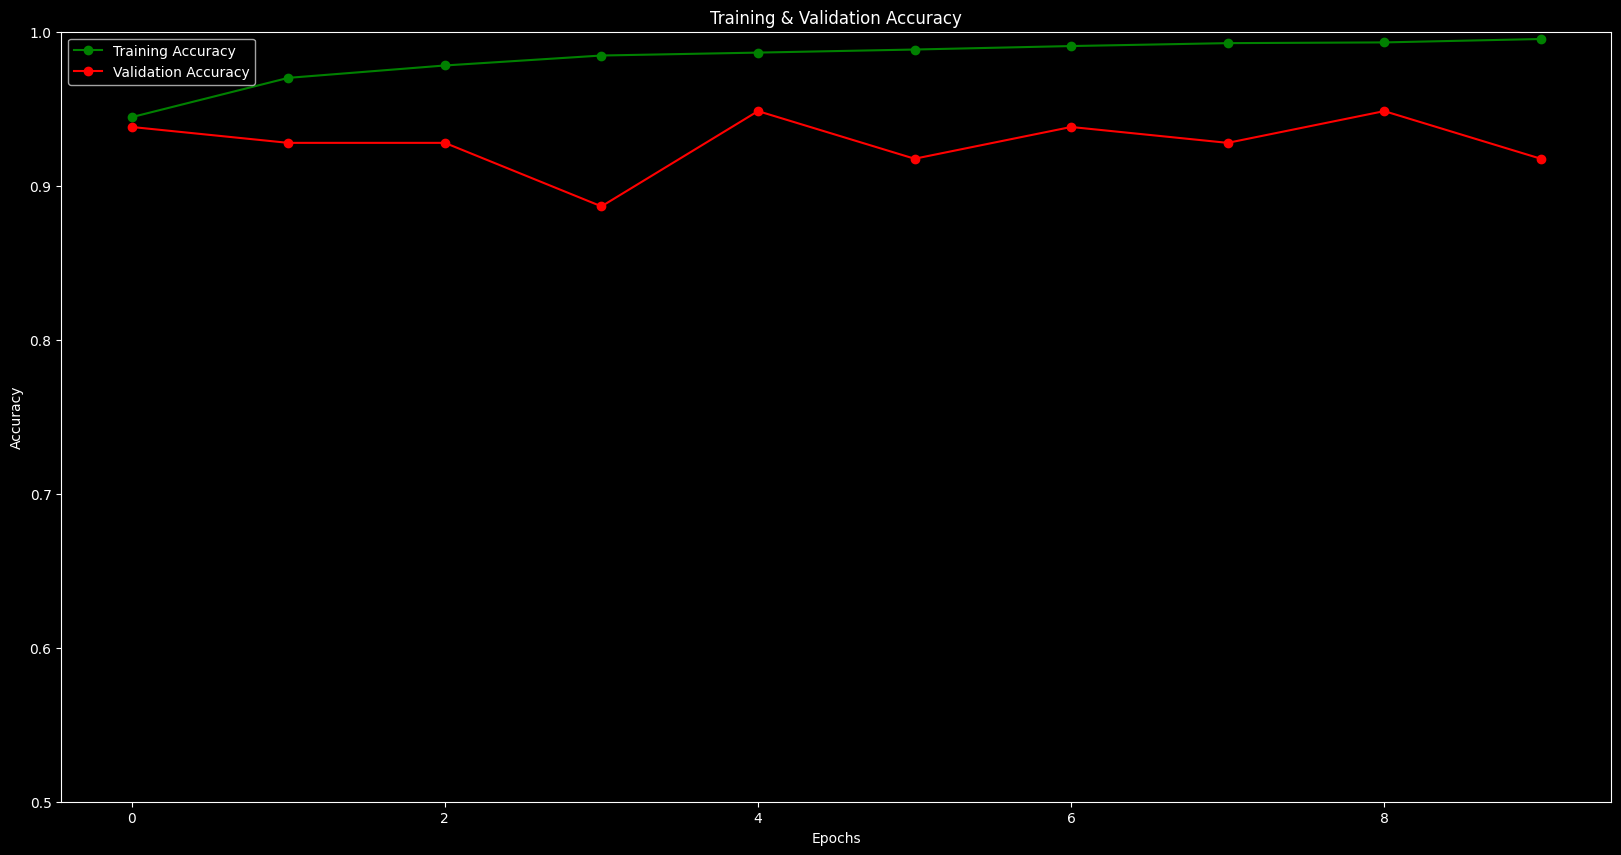

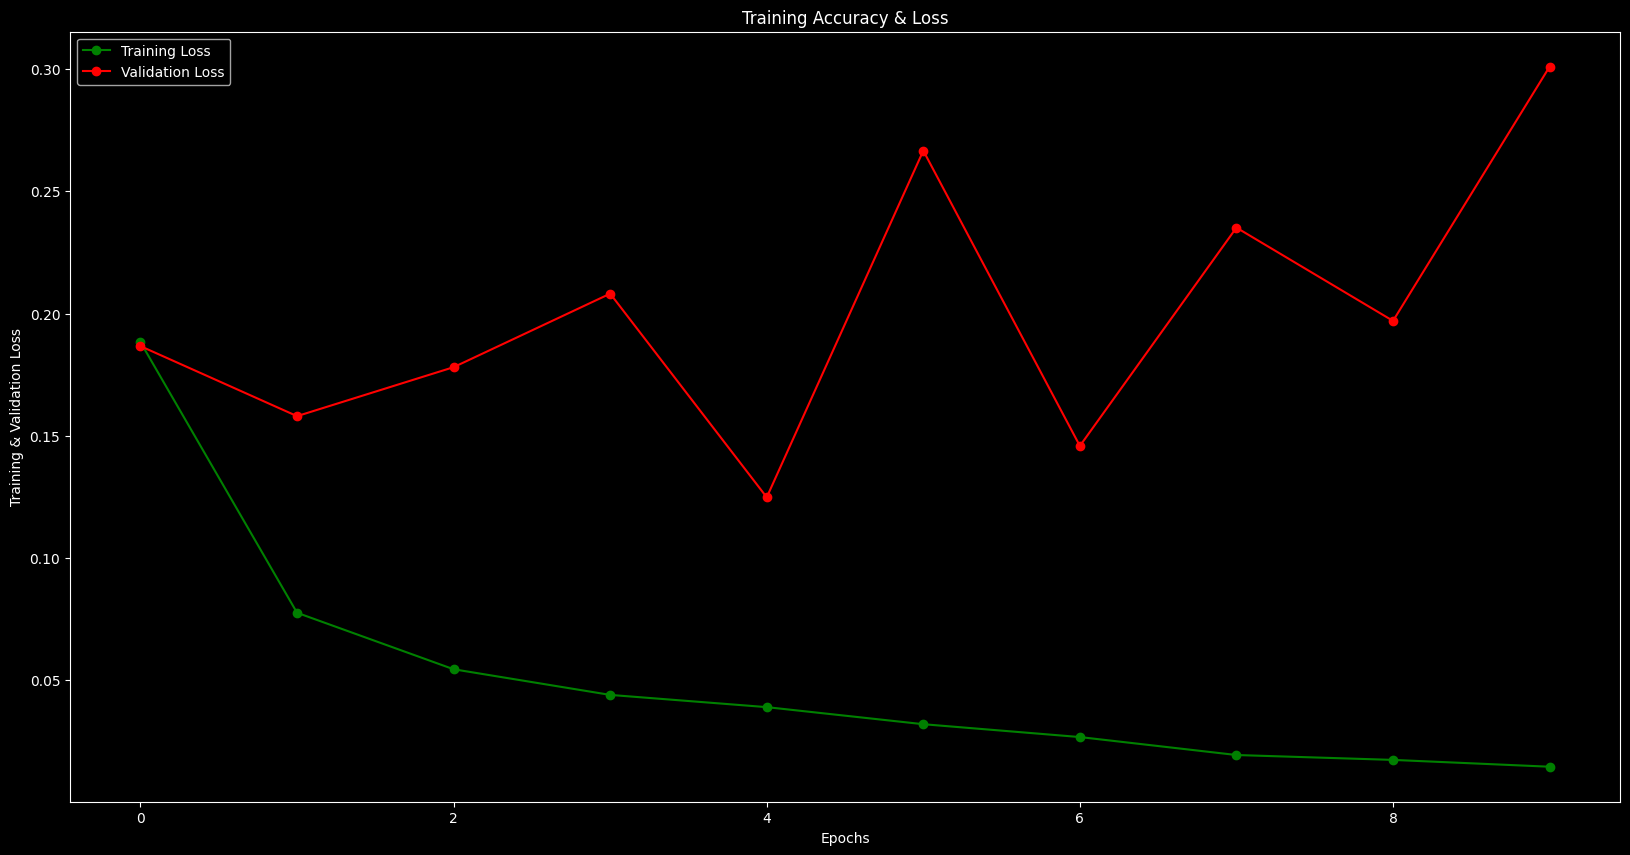

In [35]:
train_acc = history.history["accuracy"]
train_loss = history.history["loss"]
val_acc = history.history["val_accuracy"]
val_loss = history.history["val_loss"]

train_acc_df = pd.DataFrame(train_acc)
train_loss_df = pd.DataFrame(train_loss)
val_acc_df = pd.DataFrame(val_acc)
val_loss_df = pd.DataFrame(val_loss)

epochs = [i for i in range(len(train_acc_df))]

plt.figure(figsize=(20, 10))
plt.plot(epochs, train_acc_df, "go-", label="Training Accuracy")
plt.plot(epochs, val_acc_df, "ro-", label="Validation Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()
plt.ylim(0.5,1)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

plt.figure(figsize=(20, 10))
plt.plot(epochs, train_loss_df, "g-o", label="Training Loss")
plt.plot(epochs, val_loss_df, "r-o", label="Validation Loss")
plt.title("Training Accuracy & Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Training & Validation Loss")

plt.show()

### Classification Report and Confusion Matrix

#### Classification Report and Confusion Matrix for the CNN Model

In [24]:
predictions_scratch = model_scratch.predict(test_features)
predictions_scratch = predictions_scratch.reshape(1, -1)[0]
predictions_scratch = [1 if pred >= 0.5 else 0 for pred in predictions_scratch]

Cause: Unable to locate the source code of <function Model.make_predict_function.<locals>.predict_function at 0x000002A2A6DE11C0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: Unable to locate the source code of <function Model.make_predict_function.<locals>.predict_function at 0x000002A2A6DE11C0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Orig

In [25]:
# Classification report
print(
    classification_report(
        test_label,
        predictions_scratch,
        target_names=["Normal (Class 0)", "Pneumonia (Class 1)"],
    )
)

                     precision    recall  f1-score   support

   Normal (Class 0)       0.93      0.40      0.56       210
Pneumonia (Class 1)       0.74      0.98      0.85       367

           accuracy                           0.77       577
          macro avg       0.84      0.69      0.71       577
       weighted avg       0.81      0.77      0.74       577



In [26]:
cm_scratch = confusion_matrix(test_label, predictions_scratch)
cm_scratch = pd.DataFrame(cm_scratch, index=["Normal", "Pneumonia"], columns=["Normal", "Pneumonia"])

In [50]:
label_names = ['TP', 'FN', 'FP', 'TN']
label_counts_scratch = ["{0:0.0f}".format(value) for value in cm_scratch.values.flatten()]
heatmap_labels_scratch = [f"{v1}\n{v2}" for v1, v2 in zip(label_names, label_counts_scratch)]
heatmap_labels_scratch = np.asarray(heatmap_labels_scratch).reshape(2, 2)

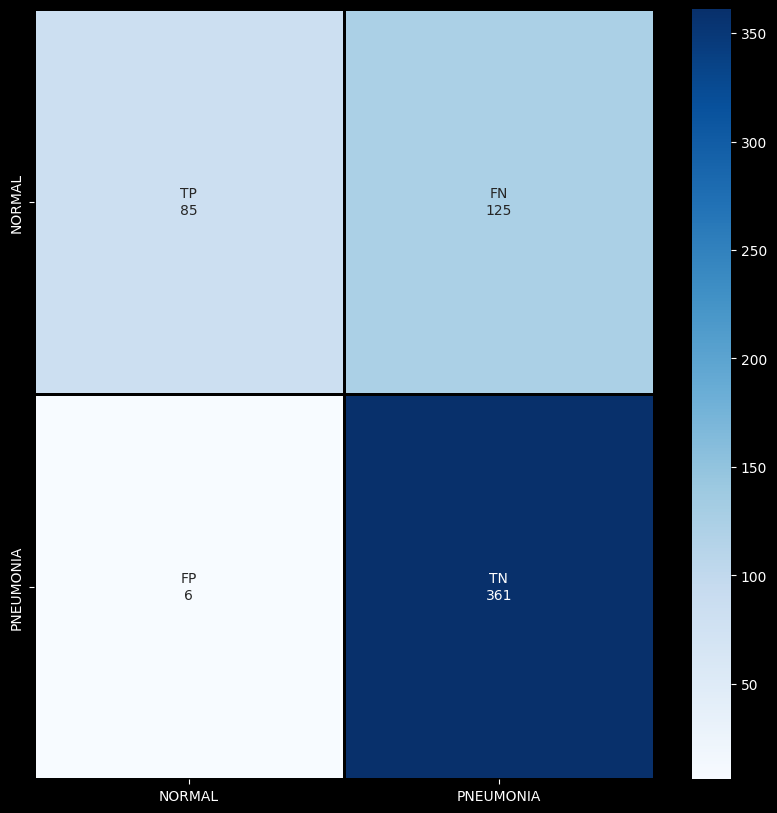

In [51]:
plt.figure(figsize=(10, 10))
sns.heatmap(
    cm_scratch,
    cmap="Blues",
    linecolor="black",
    linewidth=1,
    annot=heatmap_labels_scratch,
    fmt="",
    xticklabels=labels,
    yticklabels=labels,
)
plt.show()

#### Classification Report and Confusion Matrix for the VGG16 Model

In [36]:
predictions = model.predict(rgb_test_data)
predictions = predictions.reshape(1, -1)[0]
predictions = [1 if pred >= 0.5 else 0 for pred in predictions]

19/19 [==============================] - 16s 829ms/step


In [37]:
# Classification report
print(
    classification_report(
        test_label,
        predictions,
        target_names=["Normal (Class 0)", "Pneumonia (Class 1)"],
    )
)

                     precision    recall  f1-score   support

   Normal (Class 0)       0.97      0.54      0.70       210
Pneumonia (Class 1)       0.79      0.99      0.88       367

           accuracy                           0.83       577
          macro avg       0.88      0.77      0.79       577
       weighted avg       0.85      0.83      0.81       577



In [38]:
cm = confusion_matrix(test_label, predictions)
cm = pd.DataFrame(cm, index=["Normal", "Pneumonia"], columns=["Normal", "Pneumonia"])

In [52]:
label_counts = ["{0:0.0f}".format(value) for value in cm.values.flatten()]
heatmap_labels = [f"{v1}\n{v2}" for v1, v2 in zip(label_names, label_counts)]
heatmap_labels = np.asarray(heatmap_labels).reshape(2, 2)

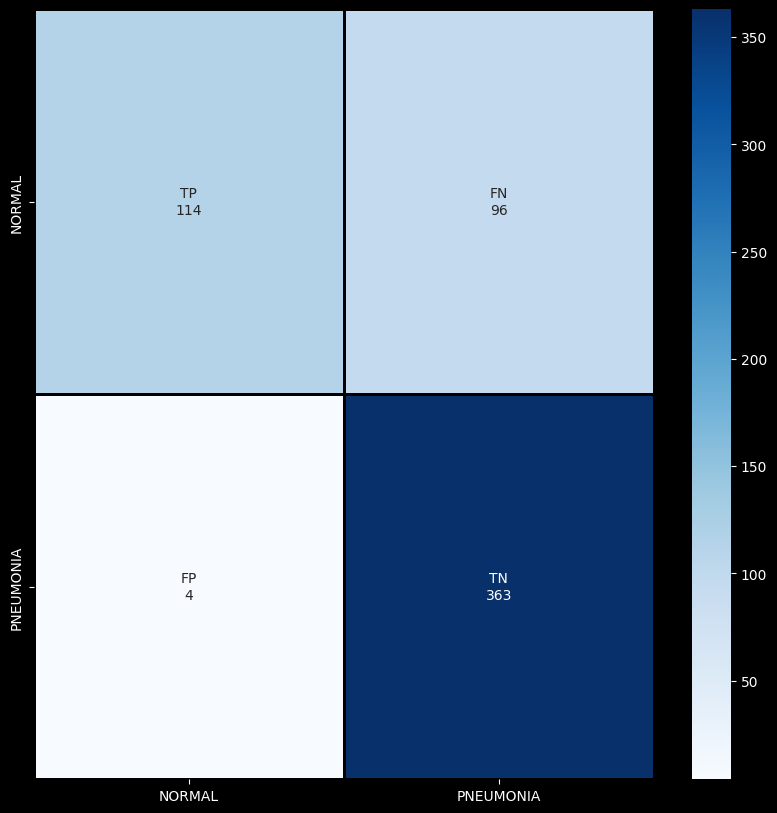

In [53]:

plt.figure(figsize=(10, 10))
sns.heatmap(
    cm,
    cmap="Blues",
    linecolor="black",
    linewidth=1,
    annot=heatmap_labels,
    fmt="",
    xticklabels=labels,
    yticklabels=labels,
)
plt.show()

### Predictions on Test Set

In [32]:
correct = np.nonzero(predictions == test_label)[0]
incorrect = np.nonzero(predictions != test_label)[0]

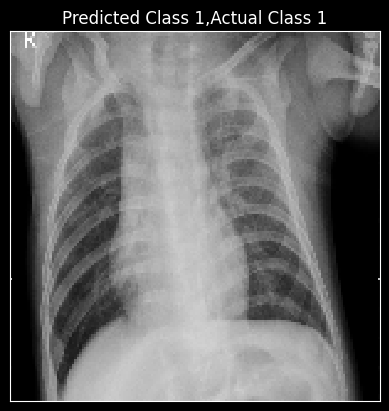

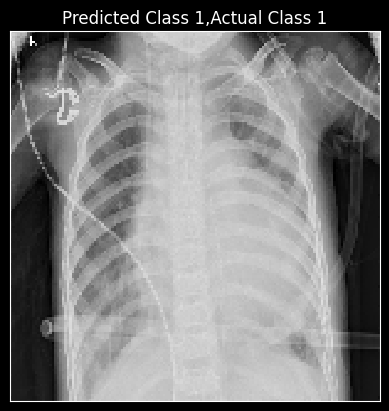

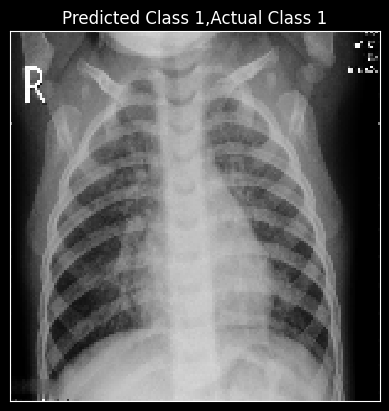

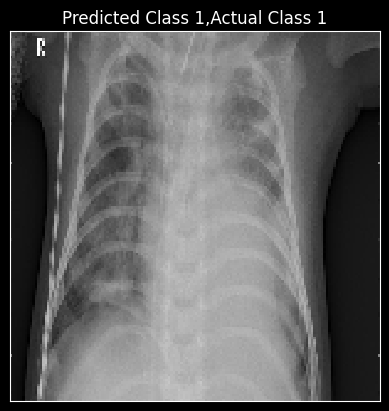

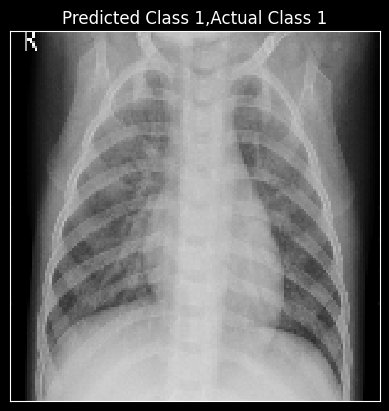

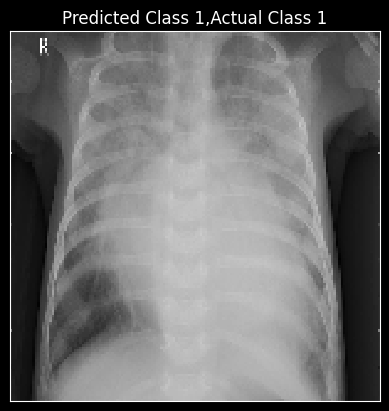

In [33]:
i = 0
for c in correct[:6]:
    plt.plot(figsize=(10,10))     
    plt.xticks([])
    plt.yticks([])
    plt.imshow(test_features[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], test_label[c]))
    plt.show()
    i += 1

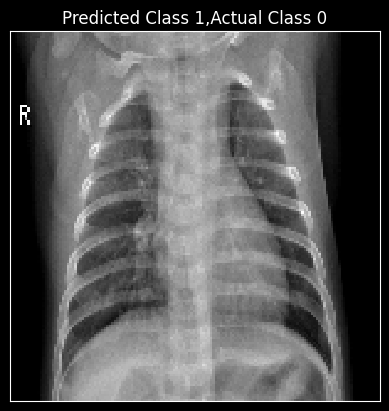

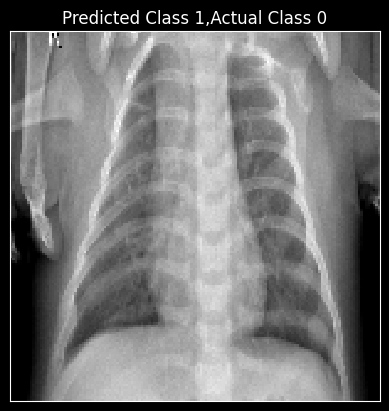

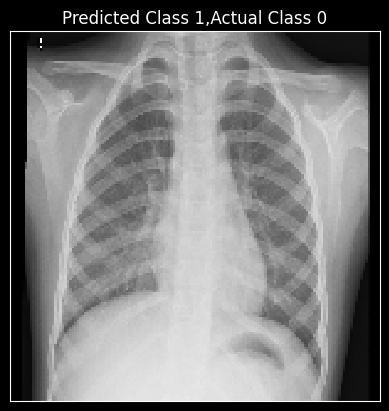

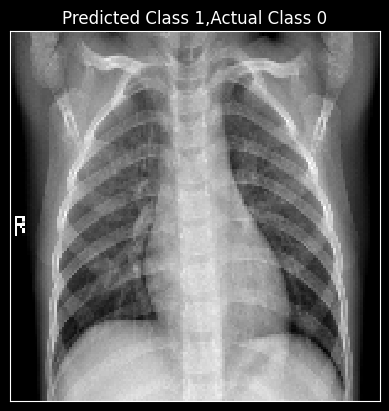

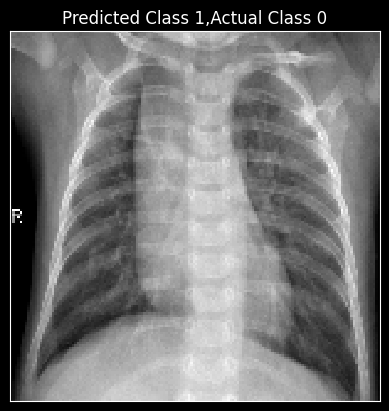

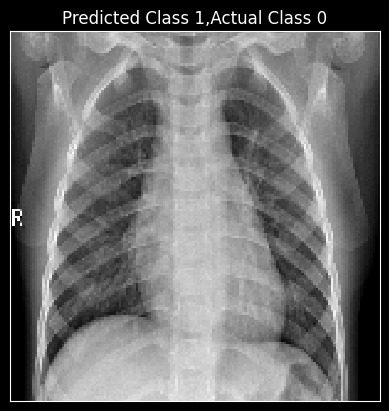

In [34]:
i = 0
for c in incorrect[:6]:
    plt.plot(figsize=(10,10))     
    plt.xticks([])
    plt.yticks([])
    plt.imshow(test_features[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], test_label[c]))
    plt.show()
    i += 1

## Conclusion

In this notebook, we have explored the task of classifying chest X-ray images as normal or pneumonia using Convolutional Neural Networks (CNNs). We started by preprocessing the dataset and performing data augmentation to address the class imbalance issue. 

We then constructed two models: a CNN model from scratch and a transfer learning model using the VGG16 architecture. Both models were trained and evaluated on the test set. 

The CNN model, built from scratch, demonstrated promising results with an accuracy of 95.19%, and validation accuracy of 91.75%. It achieved a precision of 98.26%, meaning that 98.26% of the predicted pneumonia cases were correctly identified. The recall of 92.08% indicates that 92.08% of the actual pneumonia cases were correctly classified.

On the other hand, the VGG16 model, utilizing transfer learning, achieved an accuracy of 99.53%, and validation accuracy of 94.85%. It showed a precision of 99.63%, indicating that 99.63% of the predicted pneumonia cases were correctly identified. The recall of 99.44% suggests that 99.44% of the actual pneumonia cases were correctly classified.

Overall, both models performed well in classifying chest X-ray images as normal or pneumonia. The CNN model from scratch showed potential for further improvement, while the VGG16 model demonstrated the effectiveness of transfer learning in this task. This notebook serves as a starting point for further research and development in the field of chest X-ray image classification, providing a foundation for future improvements and optimizations.